In [194]:
import numpy as np
from numpy import random
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.signal as sps

Generate input (white noise)

In [195]:
nSamples = int(1e6)
w = random.randn(nSamples)

$$H(\omega)=\frac{1+b_1 e^{-j\omega}+...+b_q e^{-jq\omega}}{1+a_1 e^{-j\omega}+...+a_p e^{-jp\omega}}$$
ARMA model

In the case of AR model, assume $q=0$ so:

$$H(\omega)=\frac{1}{1+a_1 e^{-j\omega}+...+a_p e^{-jp\omega}}$$

In [196]:
b = np.array([1]) # AR model only has 1 in the numerator
a = np.array([1, -1, 0.4])

Apply the filter

In [197]:
x = sps.lfilter(b=b,a=a,x=w)

Use Welch method to determine PSD

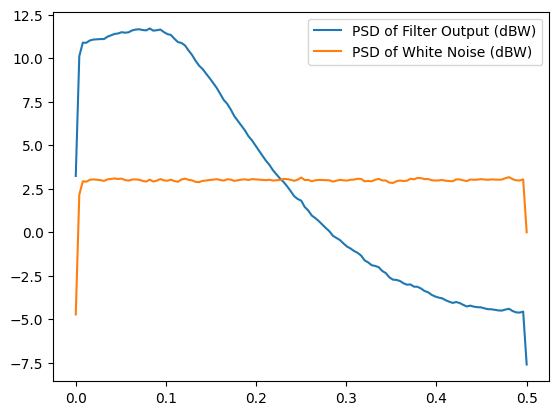

In [198]:
f, P_xx = sps.welch(x, nperseg=256)
f, P_ww = sps.welch(w, nperseg=256)

plt.plot(f,10*np.log10(P_xx),label="PSD of Filter Output (dBW)")
plt.plot(f,10*np.log10(P_ww),label="PSD of White Noise (dBW)")
plt.legend()
plt.show()

Why is the PSD of white noise at ~3 dB? Shouldn't it be 0?

Pure white noise has PSD at 1 (0 dB), but here we are including BOTH SIDES of the spectrum together (notice the x-axis only goes to 0.5), so it gets doubled. This is equivalent to adding 3 dB.

---
What about the theoretical frequency response of the filter we define?

Text(0, 0.5, '$|H(\\omega)|^2$')

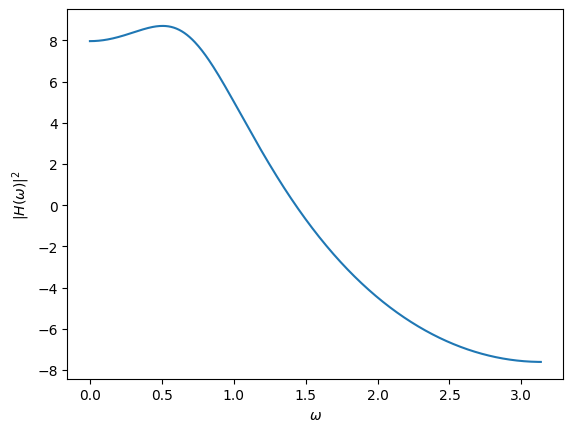

In [199]:
omega, H = sps.freqz(b,a) # Gives the theoretical frequency response
plt.plot(omega,20*np.log10(np.abs(H)))
plt.xlabel("$\omega$")
plt.ylabel("$|H(\omega)|^2$")
# Plotting the SQUARE (coefficient of 20 instead of 10) of the magnitude of frequency response of the filter define by coefficients in a and b

Let's compare the measured response to the expected response.

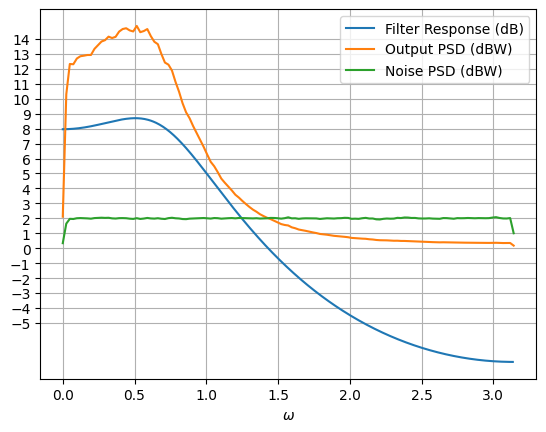

In [200]:
plt.plot(omega,20*np.log10(np.abs(H)),label="Filter Response (dB)")
plt.plot(f*2*np.pi,P_xx,label="Output PSD (dBW)")
plt.plot(f*2*np.pi,P_ww,label="Noise PSD (dBW)")
plt.xlabel("$\omega$")
plt.yticks(np.arange(-5,15,1))
plt.grid()
plt.legend()
plt.show()

# Doing This Backwards
Given $x$, solve the coefficients a1,a2,a3,... and the noise power.

In [201]:
# Filter order
p = 4

# Estimate the autocorrelation function
rx0 = np.sum(x[0:nSamples  ]*x[0:nSamples])/nSamples
rx1 = np.sum(x[0:nSamples-1]*x[1:nSamples])/nSamples
rx2 = np.sum(x[0:nSamples-2]*x[2:nSamples])/nSamples
rx3 = np.sum(x[0:nSamples-3]*x[3:nSamples])/nSamples
rx4 = np.sum(x[0:nSamples-4]*x[4:nSamples])/nSamples
# You could divide by (nSamples-k) for unbiased estimates of rx, but this leads to problems as seen in the lecture notes
# makes very little difference anyway
# note that for WSS, rx[p] and rx[-p] are equal (autocorrelation is symmetrical)

# Construct a linear system
R = np.zeros([p,p]) # Create our matrix R

R[0] = np.array([rx0,rx1,rx2,rx3]) # rx0,rx[-1],rx[-2],rx[-3]
R[1] = np.array([rx1,rx0,rx1,rx2]) # rx[1],rx[0],rx[-1],rx[-2]
R[2] = np.array([rx2,rx1,rx0,rx1])
R[3] = np.array([rx3,rx2,rx1,rx0])
# The matrix is symmetrical around the diagonal rx0's!

r = np.array([rx1,rx2,rx3,rx4])

# Solve the linear system
a = np.linalg.solve(R,-r)

for i in a:
    print("%+.3f" % (i))

-0.999
+0.398
+0.002
-0.002


As expected, the last two parameters here are near zero. This is because we have modelled a system with only three coefficients (1,-1,0.4) as a system with five (p=4, plus a0=1 as a given)

In [202]:
# Noise power
noisepower = rx0 + rx1*a[0] + rx2*a[1] + rx3*a[2] + rx4*a[3]
print(noisepower)

0.9991510984089671


As expected this is approximately 1.0, which matches the random process we used to generate the noise in the first place.

We have now applied an AR model to a signal $x$ to model it as the response of an FIR filter to a white noise input.

Later, we will develop a faster algorithm for performing this estimation.